In [1]:
from interaction_inference.simulation import gillespie_telegraph
from interaction_inference.optimization import Optimization
from interaction_inference.constraints import Constraint
from interaction_inference.dataset import Dataset
import numpy as np
import pandas as pd
import tqdm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(7)

In [3]:
def simulate_dataset_custom(name, interaction_values, gene_values, cells=1000, rate=1, runs=1, mean_capture=1, tqdm_disable=True):
    '''
    Custom dataset simulation
    '''

    # number of pairs
    gene_pairs = len(interaction_values) * len(gene_values) * runs

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # sample counter
    i = 0

    # for each sample
    for int_val in tqdm.tqdm(interaction_values, disable=tqdm_disable):
        for gene_val in gene_values:
            for k in range(runs):

                # Set reaction rate parameters
                k_on_1 = gene_val
                k_on_2 = gene_val
                k_off_1 = 1 - gene_val
                k_off_2 = 1 - gene_val
                k_tx_1 = rate
                k_tx_2 = rate
                k_deg_1 = 1
                k_deg_2 = 1
                k_reg = int_val

                # store parameters
                params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

                params = {
                    'k_on_1': k_on_1,
                    'k_on_2': k_on_2,
                    'k_off_1': k_off_1,
                    'k_off_2': k_off_2,
                    'k_tx_1': k_tx_1,
                    'k_tx_2': k_tx_2,
                    'k_deg_1': k_deg_1,
                    'k_deg_2': k_deg_2,
                    'k_reg': k_reg
                }

                # simulate sample from model
                sample = gillespie_telegraph(params, cells)

                # store counts
                counts_df.iloc[i] = sample

                # increment sample
                i += 1

    # construct dataset object
    data = Dataset(name)

    # store information
    data.count_dataset = counts_df
    data.param_dataset = params_df
    data.cells = cells
    data.gene_pairs = gene_pairs
    data.beta = np.array([1.0 for j in range(cells)])

    # beta parameter
    b = (1 / mean_capture) - 1

    # capture vector
    if b == 0:
        beta = np.ones(cells)
    else:
        beta = rng.beta(1, b, size=cells)

    # downsample
    data = data.downsample("table", beta)

    return data

In [4]:
def construct_result_array(opt, interaction_values, gene_values, runs):
        
    # shape
    shape = (len(interaction_values), len(gene_values))

    # array for result objects
    result_array = np.zeros(shape)

    # sample counter
    i = 0

    # for each sample
    for j, _ in enumerate(interaction_values):
        for k, _ in enumerate(gene_values):
            for l in range(runs):

                # get result
                if opt.result_dict[i]['status'] == "INFEASIBLE":
                    result_array[j, k] += 1 / runs

                # increment counter
                i += 1

    return result_array

In [5]:
def plot(opt, interaction_values, gene_values, runs, title, caption, figsize=(6, 6)):

    # analyse
    array = construct_result_array(opt, interaction_values, gene_values, runs)

    fig, axs = plt.subplots(figsize=figsize)

    #fig.suptitle("Infeasibility %")

    #plt.tight_layout()

    cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)

    vmin, vmax = 0, 1

    img = axs.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_xlabel("Gene on %")
    axs.set_xticks(range(len(gene_values)))
    axs.set_xticklabels(gene_values)
    axs.set_ylabel("Interaction strength")
    axs.set_yticks(range(len(interaction_values)))
    axs.set_yticklabels(interaction_values)
    axs.set_title(title)

    cbar = plt.colorbar(img, ax=axs)
    cbar.set_label(caption)

# 100% capture

In [6]:
# settings
gene_values = [1.0, 0.9, 0.8, 0.6, 0.4, 0.2]
interaction_values = [0, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]
rate = 5
runs = 3
mean_capture = 1

# simulate
data = simulate_dataset_custom("data", interaction_values, gene_values, cells=1000, rate=rate, runs=runs, mean_capture=mean_capture, tqdm_disable=False)

100%|██████████| 10/10 [08:49<00:00, 52.99s/it]


In [17]:
# estimate
data.bootstrap_marginal_fm()
data.bootstrap_joint_fm()
data.bootstrap_marginal_probabilities()
data.bootstrap_joint_probabilities()

In [ ]:
ind_BD_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME=True,
    k_reg=True,
    k_deg_1=True
)

ind_BD_downsampled = Optimization(data, ind_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [01:19<00:00,  2.27it/s]


In [28]:
int_BD_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME=True,
    k_deg_1=True
)

int_BD_downsampled = Optimization(data, int_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [02:53<00:00,  1.04it/s]


In [30]:
ind_TE_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME_TE=True,
    downsampled_TE_link=True,
    k_reg=True,
    k_deg_1=True
)

ind_TE_downsampled = Optimization(data, ind_TE_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [08:26<00:00,  2.81s/it]


In [32]:
int_TE_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME_TE=True,
    downsampled_TE_link=True,
    k_deg_1=True
)

int_TE_downsampled = Optimization(data, int_TE_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [02:08<00:00,  1.40it/s]


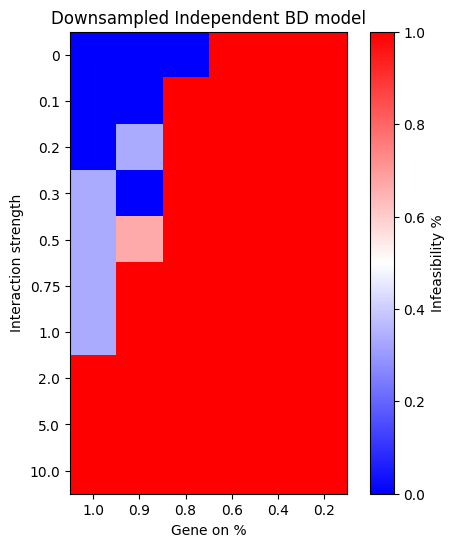

In [35]:
plot(ind_BD_downsampled, interaction_values, gene_values, runs, "Downsampled Independent BD model", "Infeasibility %", figsize=(6, 6))

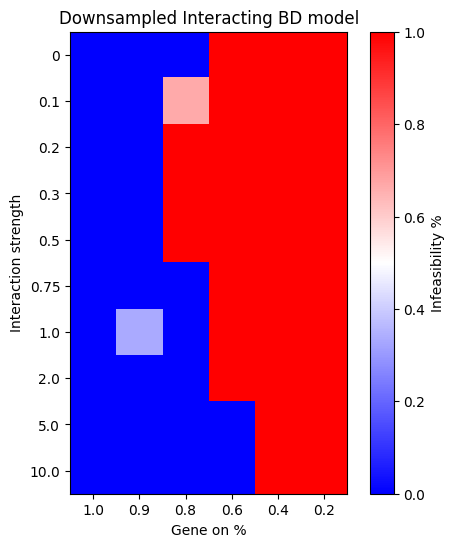

In [29]:
plot(int_BD_downsampled, interaction_values, gene_values, runs, "Downsampled Interacting BD model", "Infeasibility %", figsize=(6, 6))

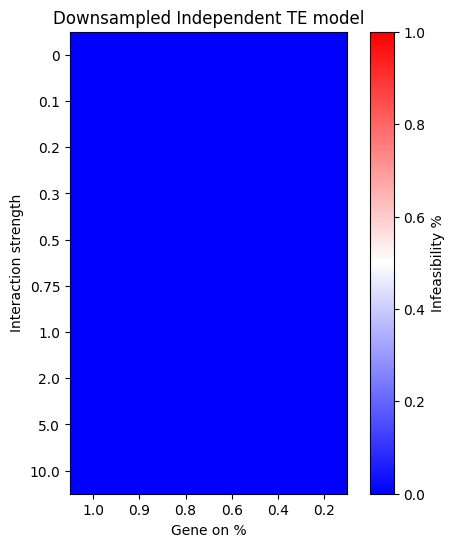

In [31]:
plot(ind_TE_downsampled, interaction_values, gene_values, runs, "Downsampled Independent TE model", "Infeasibility %", figsize=(6, 6))

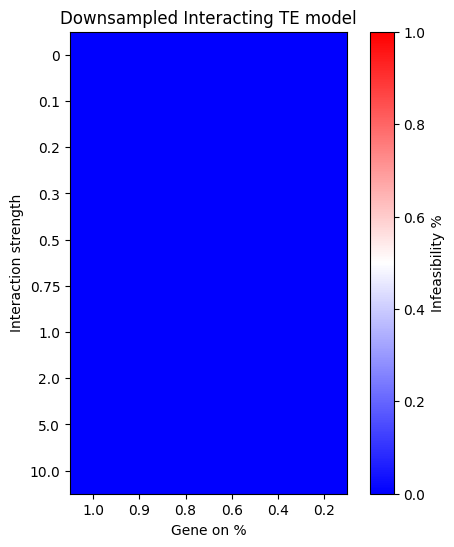

In [34]:
plot(int_TE_downsampled, interaction_values, gene_values, runs, "Downsampled Interacting TE model", "Infeasibility %", figsize=(6, 6))

# 90% capture

In [7]:
# capture
mean_capture = 0.9
b = (1 / mean_capture) - 1
beta = rng.beta(1, b, size=1000)

# downsample
data_90 = data.downsample("test", beta)

## Downsampled

In [37]:
# estimate
data_90.bootstrap_marginal_fm()
data_90.bootstrap_joint_fm()
data_90.bootstrap_marginal_probabilities()
data_90.bootstrap_joint_probabilities()

In [38]:
ind_BD_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME=True,
    k_reg=True,
    k_deg_1=True
)

ind_BD_downsampled_90 = Optimization(data_90, ind_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [05:11<00:00,  1.73s/it]


In [40]:
int_BD_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME=True,
    k_deg_1=True
)

int_BD_downsampled_90 = Optimization(data_90, int_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [05:59<00:00,  2.00s/it]


In [42]:
ind_TE_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME_TE=True,
    downsampled_TE_link=True,
    k_reg=True,
    k_deg_1=True
)

ind_TE_downsampled_90 = Optimization(data_90, ind_TE_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [03:28<00:00,  1.16s/it]


In [44]:
int_TE_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME_TE=True,
    downsampled_TE_link=True,
    k_deg_1=True
)

int_TE_downsampled_90 = Optimization(data_90, int_TE_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [02:19<00:00,  1.29it/s]


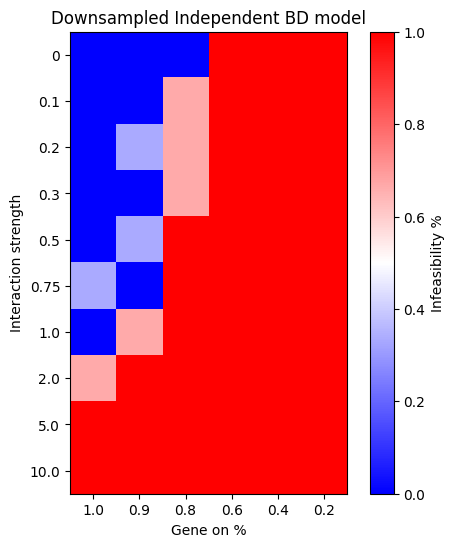

In [39]:
plot(ind_BD_downsampled_90, interaction_values, gene_values, runs, "Downsampled Independent BD model", "Infeasibility %", figsize=(6, 6))

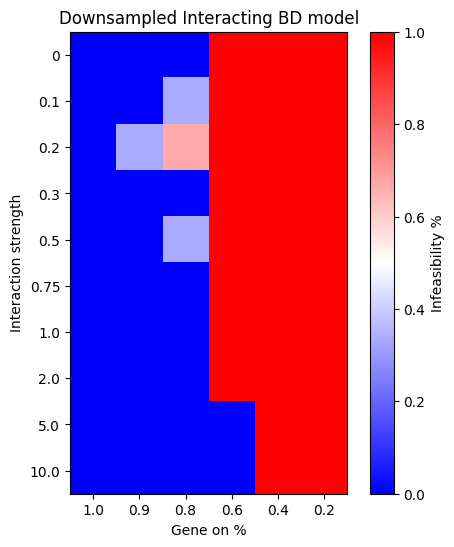

In [41]:
plot(int_BD_downsampled_90, interaction_values, gene_values, runs, "Downsampled Interacting BD model", "Infeasibility %", figsize=(6, 6))

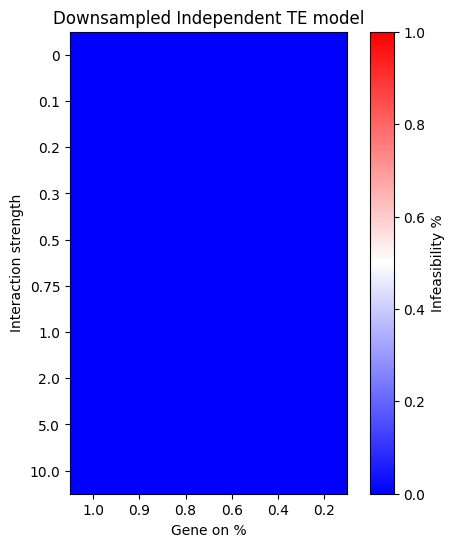

In [43]:
plot(ind_TE_downsampled_90, interaction_values, gene_values, runs, "Downsampled Independent TE model", "Infeasibility %", figsize=(6, 6))

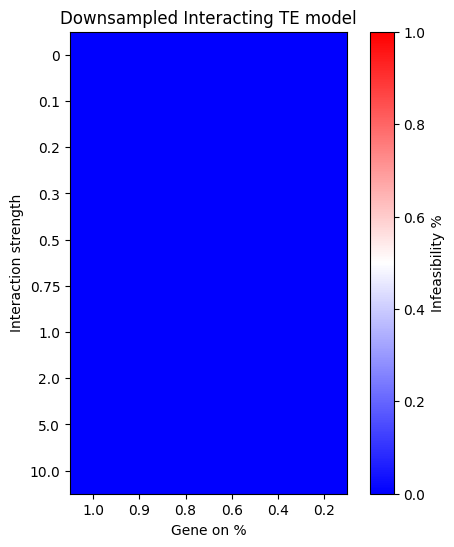

In [46]:
plot(int_TE_downsampled_90, interaction_values, gene_values, runs, "Downsampled Interacting TE model", "Infeasibility %", figsize=(6, 6))

## B-method

In [47]:
# estimate
data_90.compute_probabilities(display=False, tqdm_disable=False)

100%|██████████| 90/90 [00:03<00:00, 23.29it/s]


In [ ]:
ind_BD_constraints = Constraint(
    joint_probability=False,
    factorization=False,
    marginal_probability_1=True,
    marginal_probability_2=True,
    marginal_CME_1=True,
    marginal_CME_2=True,
    k_deg_1=True,
    k_deg_2=True
)

ind_BD_B_90 = Optimization(data_90, ind_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [04:21<00:00,  1.45s/it]


In [51]:
ind_TE_constraints = Constraint(
    joint_probability=False,
    factorization=False,
    marginal_probability_1=True,
    marginal_probability_2=True,
    marginal_TE_equality=True,
    marginal_CME_TE=True,
    k_deg_1=True,
    k_deg_2=True
) 

ind_TE_B_90 = Optimization(data_90, ind_TE_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

 14%|█▍        | 25/180 [14:05<1:27:24, 33.84s/it]


KeyboardInterrupt: 

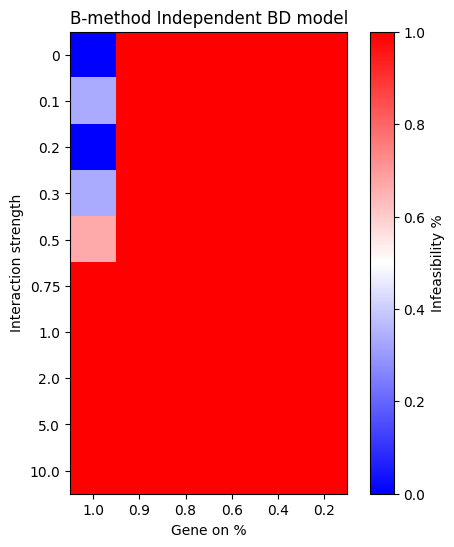

In [50]:
plot(ind_BD_B_90, interaction_values, gene_values, runs, "B-method Independent BD model", "Infeasibility %", figsize=(6, 6))

In [ ]:
plot(ind_TE_B_90, interaction_values, gene_values, runs, "B-method Independent TE model", "Infeasibility %", figsize=(6, 6))

## Moments

In [14]:
# estimate
data_90.compute_moments(tqdm_disable=False)

100%|██████████| 180/180 [00:16<00:00, 10.78it/s]


In [15]:
# adjust truncation
for sample, trunc in data_90.moment_extent_OG.items():
    max_x1_OG = trunc['max_x1_OG']
    max_x2_OG = trunc['max_x2_OG']
    data_90.moment_extent_OG[sample]['max_x1_OG'] = max(25, max_x1_OG)
    data_90.moment_extent_OG[sample]['max_x2_OG'] = max(25, max_x2_OG)

In [16]:
# full constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = True,
    moment_factorization = True,
    moment_IBD           = True,
    marginal_CME_1       = True,
    marginal_CME_2       = True,
    k_deg_1              = True,
    k_deg_2              = True
)

ind_BD_moment_90 = Optimization(data_90, constraints, tqdm_disable=False, print_solution=False, time_limit=30)

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:02<00:00, 73.78it/s] 


In [18]:
# full constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_marginal_joint_link = True,
    moment_sum           = True,
    CME                  = True,
    k_deg_1              = True
)

int_BD_moment_90 = Optimization(data_90, constraints, tqdm_disable=False, print_solution=False, time_limit=30)

  0%|          | 0/180 [00:31<?, ?it/s]


KeyboardInterrupt: 

In [109]:
# construct constraints
constraints = Constraint(
    moment_bound         = True,
    moment_link          = True,
    moment_sum           = False,
    moment_factorization = True,
    moment_ITE           = True,
    marginal_CME_TE      = False,
    marginal_TE_equality = False,
    k_deg_1              = False,
    k_deg_2              = False
)

ind_TE_moment_90 = Optimization(data_90, constraints, tqdm_disable=False, print_solution=False, time_limit=30)

  0%|          | 0/180 [00:00<?, ?it/s]

  7%|▋         | 13/180 [02:19<29:48, 10.71s/it]


KeyboardInterrupt: 

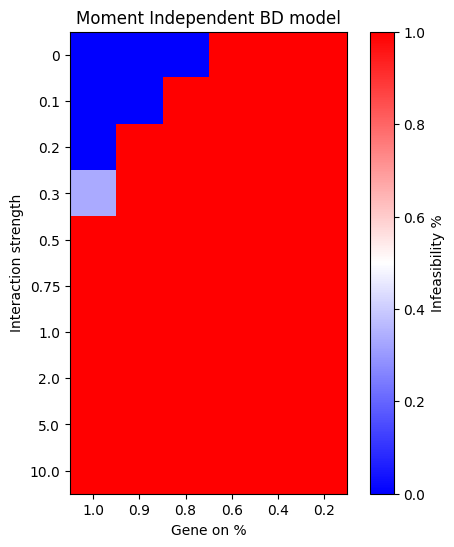

In [17]:
plot(ind_BD_moment_90, interaction_values, gene_values, runs, "Moment Independent BD model", "Infeasibility %", figsize=(6, 6))

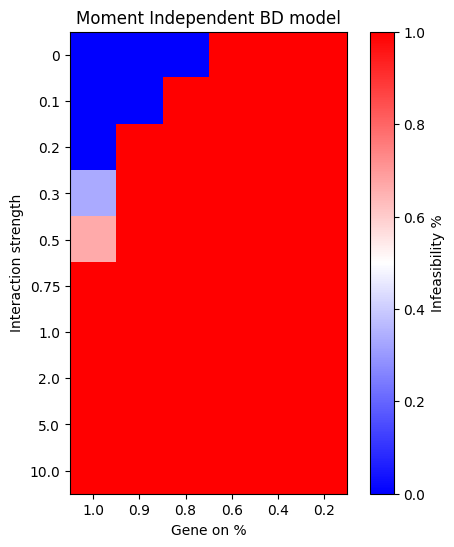

In [103]:
plot(ind_BD_moment_90, interaction_values, gene_values, runs, "Moment Independent BD model", "Infeasibility %", figsize=(6, 6))

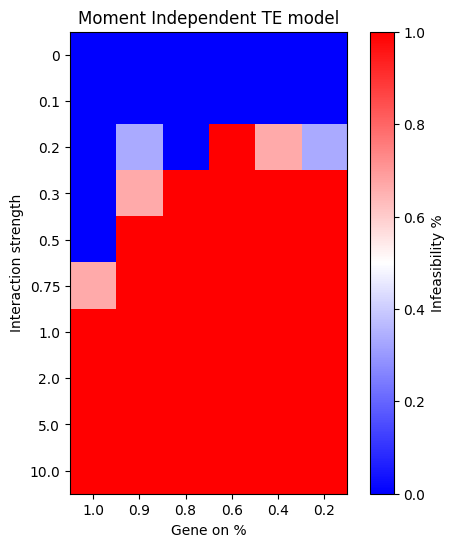

In [98]:
plot(ind_TE_moment_90, interaction_values, gene_values, runs, "Moment Independent TE model", "Infeasibility %", figsize=(6, 6))

# 50% capture

In [70]:
# capture
mean_capture = 0.5
b = (1 / mean_capture) - 1
beta = rng.beta(1, b, size=1000)

# threshold (B-method explodes)
beta[beta < 0.01] = 0.01

# downsample
data_50 = data.downsample("test_50", beta)

## Downsampled

In [71]:
# estimate
data_50.bootstrap_marginal_fm()
data_50.bootstrap_joint_fm()
data_50.bootstrap_marginal_probabilities()
data_50.bootstrap_joint_probabilities()

In [74]:
ind_BD_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME=True,
    k_reg=True,
    k_deg_1=True
)

ind_BD_downsampled_50 = Optimization(data_50, ind_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [02:35<00:00,  1.16it/s]


In [76]:
int_BD_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME=True,
    k_deg_1=True
)

int_BD_downsampled_50 = Optimization(data_50, int_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [04:44<00:00,  1.58s/it]


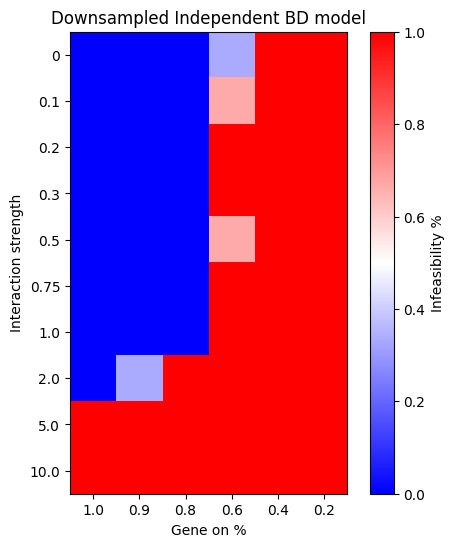

In [75]:
plot(ind_BD_downsampled_50, interaction_values, gene_values, runs, "Downsampled Independent BD model", "Infeasibility %", figsize=(6, 6))

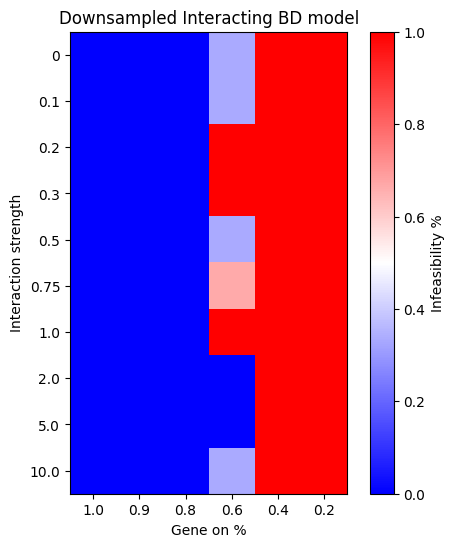

In [77]:
plot(int_BD_downsampled_50, interaction_values, gene_values, runs, "Downsampled Interacting BD model", "Infeasibility %", figsize=(6, 6))

## B-method

In [72]:
# estimate
data_50.compute_probabilities(display=False, tqdm_disable=False)

100%|██████████| 49/49 [00:06<00:00,  7.95it/s]


In [78]:
ind_BD_constraints = Constraint(
    joint_probability=False,
    factorization=False,
    marginal_probability_1=True,
    marginal_probability_2=True,
    marginal_CME_1=True,
    marginal_CME_2=True,
    k_deg_1=True,
    k_deg_2=True
)

ind_BD_B_50 = Optimization(data_50, ind_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [12:11<00:00,  4.06s/it]


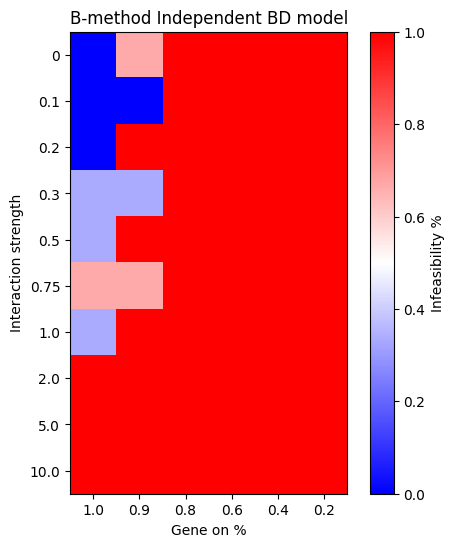

In [79]:
plot(ind_BD_B_50, interaction_values, gene_values, runs, "B-method Independent BD model", "Infeasibility %", figsize=(6, 6))

# 25% capture

In [80]:
# capture
mean_capture = 0.25
b = (1 / mean_capture) - 1
beta = rng.beta(1, b, size=1000)

# threshold (B-method explodes)
beta[beta < 0.01] = 0.01

# downsample
data_25 = data.downsample("test_25", beta)

## Downsampled

In [81]:
# estimate
data_25.bootstrap_marginal_fm()
data_25.bootstrap_joint_fm()
data_25.bootstrap_marginal_probabilities()
data_25.bootstrap_joint_probabilities()

In [82]:
ind_BD_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME=True,
    k_reg=True,
    k_deg_1=True
)

ind_BD_downsampled_25 = Optimization(data_25, ind_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [00:28<00:00,  6.35it/s]


In [87]:
int_BD_constraints = Constraint(
    downsampled_probability=True,
    downsampled_CME=True,
    k_deg_1=True
)

int_BD_downsampled_25 = Optimization(data_25, int_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

100%|██████████| 180/180 [01:58<00:00,  1.52it/s]


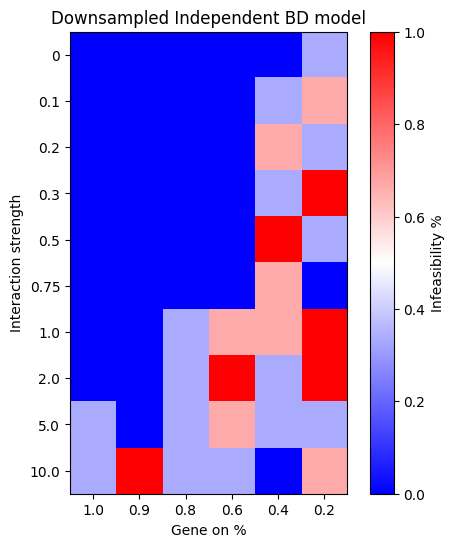

In [83]:
plot(ind_BD_downsampled_25, interaction_values, gene_values, runs, "Downsampled Independent BD model", "Infeasibility %", figsize=(6, 6))

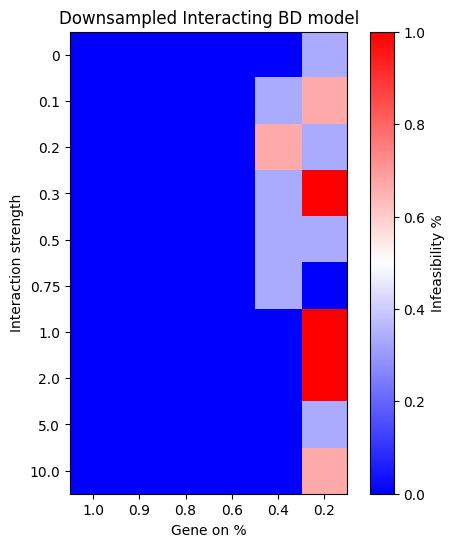

In [88]:
plot(int_BD_downsampled_25, interaction_values, gene_values, runs, "Downsampled Interacting BD model", "Infeasibility %", figsize=(6, 6))

## B-method

In [84]:
# estimate
data_25.compute_probabilities(display=False, tqdm_disable=False)

100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


In [89]:
ind_BD_constraints = Constraint(
    joint_probability=False,
    factorization=False,
    marginal_probability_1=True,
    marginal_probability_2=True,
    marginal_CME_1=True,
    marginal_CME_2=True,
    k_deg_1=True,
    k_deg_2=True
)

ind_BD_B_25 = Optimization(data_25, ind_BD_constraints, tqdm_disable=False, print_solution=False, time_limit=30)

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [23:20<00:00,  7.78s/it]


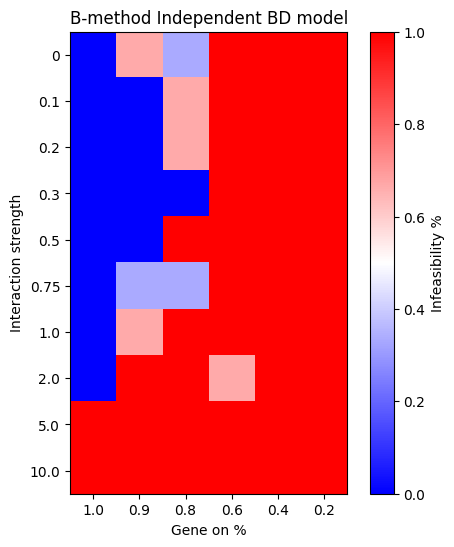

In [90]:
plot(ind_BD_B_25, interaction_values, gene_values, runs, "B-method Independent BD model", "Infeasibility %", figsize=(6, 6))